This notebook is for experiments with how far we could push the multif0 results on the bach10 dataset by injecting extra information. We constrained the maximum polyphony to 4 and did a sweep across thresholds

In [1]:
cd ../deepsalience/

/scratch/rmb456/multif0/deepsalience


In [2]:
import compute_training_data as C
import evaluate
import numpy as np
import scipy
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
import mir_eval
%matplotlib inline

In [3]:
def pitch_activations_to_mf0_polyphony_constraint(pitch_activation_mat, thresh):
    """Convert a pitch activation map to multif0 format by thresholding values
    at thresh
    """
    freqs = C.get_freq_grid()
    times = C.get_time_grid(pitch_activation_mat.shape[1])

    peak_thresh_mat = np.zeros(pitch_activation_mat.shape)
    peaks = scipy.signal.argrelmax(pitch_activation_mat, axis=0)
    peak_thresh_mat[peaks] = pitch_activation_mat[peaks]

    idx = np.where(peak_thresh_mat >= thresh)

    est_freq_idx = [[] for _ in range(len(times))]
    
    for f, t in zip(idx[0], idx[1]):
        est_freq_idx[t].append(f)
    
    est_freqs = []
    for t, f_list in zip(range(len(times)), est_freq_idx):
        if len(f_list) > 0:
            amplitudes = [peak_thresh_mat[f, t] for f in f_list]
            ordered_idx = np.flip(np.argsort(amplitudes), 0)
            est_freqs.append(
                np.array([freqs[f_list[i]] for i in ordered_idx[:4]])
            )
        else:
            est_freqs.append(np.array([]))
        

    return times, est_freqs

In [6]:
fpaths = glob.glob("../comparisons/multif0/datasets/bach10/gt_F0/*_GTF0s.txt")
trackids = ['_'.join(os.path.basename(f).split('_')[:2]) for f in fpaths]

thresh_vals = np.arange(0, 1, 0.05)

all_scores = {t: [] for t in thresh_vals}
for t in thresh_vals:
    for trackid in trackids:
        cnn_npy = "../experiment_output_submission/multif0_exper11_batchin/{}_prediction.npy".format(trackid)
        gt_output = '../comparisons/multif0/datasets/bach10/gt_F0/{}_GTF0s.txt'.format(trackid)
        Y = np.load(cnn_npy)
        c_times, c_freqs = pitch_activations_to_mf0_polyphony_constraint(Y, t)
        g_times, g_freqs = mir_eval.io.load_ragged_time_series(gt_output)
        scores = mir_eval.multipitch.evaluate(g_times, g_freqs, c_times, c_freqs)
        all_scores[t].append(scores)


/home/rmb456/anaconda2/lib/python2.7/site-packages/mir_eval/multipitch.py:410: UserWarning: Estimate times not equal to reference times. Resampling to common time base.
  warnings.warn("Estimate times not equal to reference times. "


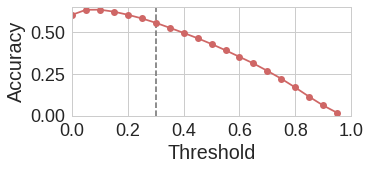

In [10]:
import seaborn as sns


acc = [np.mean([s['Accuracy'] for s in all_scores[t]]) for t in thresh_vals]
recall = [np.mean([s['Recall'] for s in all_scores[t]]) for t in thresh_vals]
precision = [np.mean([s['Precision'] for s in all_scores[t]]) for t in thresh_vals]
fmeasure = [2.0*p*r/(p+r) for (r, p) in zip(recall, precision)]

plt.figure(figsize=(5, 2))
sns.set(font_scale=1.8)
sns.set_style('whitegrid')
# plt.subplot(121)
plt.plot([0.3, 0.3], [0, 0.65], '--', color='grey')
plt.plot(thresh_vals, acc, 'o-', color='#CF6766')
plt.ylabel("Accuracy")
plt.xlabel("Threshold")

plt.xlim([0, 1])
plt.ylim([0, 0.65])

plt.savefig('../paper-figs/bach10_threshsweep.pdf', format='pdf', bbox_inches='tight')

# plt.subplot(122)
# plt.plot([0.3, 0.3], [0, 1], '--', color='grey')
# plt.plot(thresh_vals, fmeasure, '.')
# plt.ylabel("F1")
# plt.xlabel("Threshold")

# plt.subplot(223)
# plt.plot([0.3, 0.3], [0, 1], '--', color='grey')
# plt.plot(thresh_vals, recall, '.')
# plt.ylabel("Recall")
# plt.xlabel("Threshold")


# plt.subplot(224)
# plt.plot([0.3, 0.3], [0, 1], '--', color='grey')
# plt.plot(thresh_vals, precision, '.')
# plt.ylabel("Precision")
# plt.xlabel("Threshold")


In [85]:
score_df = pd.DataFrame(all_scores[0.1])
score_df.describe()

,Accuracy,Chroma Accuracy,Chroma False Alarm Error,Chroma Miss Error,Chroma Precision,Chroma Recall,Chroma Substitution Error,Chroma Total Error,False Alarm Error,Miss Error,Precision,Recall,Substitution Error,Total Error
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.634347,0.691888,0.054289,0.098223,0.836800,0.799757,0.102020,0.254532,0.054289,0.098223,0.794106,0.759038,0.142739,0.295251
std,0.022859,0.020611,0.011758,0.019667,0.019232,0.016962,0.016463,0.018794,0.011758,0.019667,0.018950,0.020654,0.018177,0.020463
min,0.604676,0.655953,0.040058,0.066962,0.809403,0.775782,0.083172,0.226029,0.040058,0.066962,0.769974,0.730697,0.113183,0.260881
25%,0.615228,0.679233,0.044641,0.089173,0.821190,0.786944,0.088359,0.244827,0.044641,0.089173,0.777149,0.741057,0.132493,0.277610
50%,0.631486,0.692971,0.053360,0.100006,0.839084,0.796737,0.099478,0.257800,0.053360,0.100006,0.794008,0.759225,0.137646,0.298690
75%,0.652335,0.707832,0.057762,0.107963,0.851983,0.814959,0.110850,0.259894,0.057762,0.107963,0.806882,0.778190,0.155218,0.311039
max,0.669793,0.721813,0.074285,0.134609,0.862183,0.822254,0.128076,0.282435,0.074285,0.134609,0.823624,0.787402,0.171715,0.318719
